## XGBoost

We are using the XGBoost package (https://xgboost.readthedocs.io/en/latest/index.html , version 1.5.0) in this notebook .We will use XGBClassifier to solve the classification problem which we predict wether a PA form will be approved base on information provided on the PA form. Our data features are 'correct_diagnosis', 'tried_and_failed', 'contraindication', 'drug'(drug type), 'bin'(payer id),'reject_code', which are all categorical. Our label will be 'pa_approved'. 

In [1]:
#import pacakges
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
#read data
cmm_pa_clf_read = pd.read_csv("../Data/cmm_pa_clf.csv",index_col = 0)
cmm_pa_clf_data = cmm_pa_clf_read.drop(columns = 'pa_approved').copy()
cmm_pa_clf_target = cmm_pa_clf_read['pa_approved'].copy()
X_train,X_test,Y_train,Y_test= train_test_split(cmm_pa_clf_data, cmm_pa_clf_target, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = cmm_pa_clf_target)

## Baseline:
We predoct that all PA form will be approved. In this case the true positive rate = false positive rate = 1, the ROC-AUC score of our baseline model is 0.5. The error of this predictor is 100-73.445 = 26.555.

## XGBClassifier
We will using GBTree booster; our learning objective is the binary logisrtic regression loss fuction; our evaluation metric will be ROC-AUC scores. 

We will explore the performance of the algorithm for:  
tree_method to be 'approx' or 'hist'  
max_depeth to be 1, 2, or 3  
subsample rate to be 0.5, 0.8, 1  
n_estimators up to 100  
eta to be 0.01,0.1,0.5,1,3,7,10  

Let's first explore the different tree methods and fix all other parameters:

In [4]:
skf = StratifiedKFold(n_splits=5,shuffle = True, random_state = 10475)
roc_auc = np.zeros((2,5,100)) #roc_auc[tree_methods,validation index,n_estimators]
acc = np.zeros((2,5,100)) #acc[tree_methods,validation index,n_estimators]
i = 0
for train_index, test_index in skf.split(X_train,Y_train):
    X_train_train, X_train_hold = X_train.iloc[train_index], X_train.iloc[test_index]
    Y_train_train, Y_train_hold = Y_train.iloc[train_index], Y_train.iloc[test_index]
    j = 0
    for tree_methods in ['approx','hist']:
        xgb_clf= xgb.XGBClassifier(booster = 'gbtree',
                                   objective = 'binary:logistic',
                                   max_depth = 1,
                                   subsample = 0.5,
                                   tree_method = tree_methods,
                                   eval_metric = ['auc','error'],
                                   n_estimators= 100,
                                   eta = 0.1,
                                   use_label_encoder=False)

        xgb_clf.fit(X_train_train,Y_train_train,
                    eval_set = [(X_train_hold,Y_train_hold)],verbose = False)
        roc_auc[j,i,:] = xgb_clf.evals_result()['validation_0']['auc']
        acc[j,i,:] = xgb_clf.evals_result()['validation_0']['error']
        j = j+1
    i = i+1

In [9]:
roc_auc_approx_mean = roc_auc.mean(1)[0]
roc_auc_hist_mean = roc_auc.mean(1)[1]
acc_approx_mean = acc.mean(1)[0]
acc_hist_mean = acc.mean(1)[1]

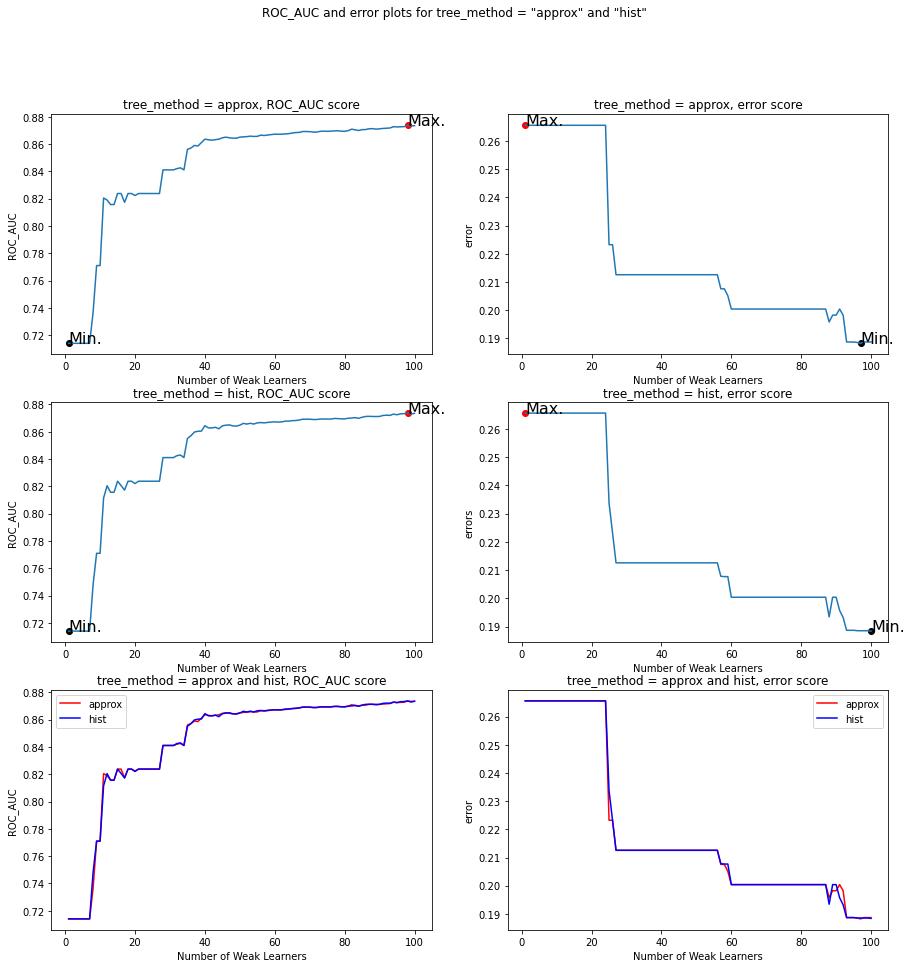

In [31]:
fig, axs = plt.subplots(3,2,figsize=(15,15))
fig.suptitle('ROC_AUC and error plots for tree_method = "approx" and "hist" ')
axs[0,0].plot(range(1,len(roc_auc_approx_mean)+1), roc_auc_approx_mean)
axs[0,0].scatter([range(1,len(roc_auc_approx_mean)+1)[np.argmin(roc_auc_approx_mean)]], 
            [np.min(roc_auc_approx_mean)], c='k')
axs[0,0].scatter([range(1,len(roc_auc_approx_mean)+1)[np.argmax(roc_auc_approx_mean)]], 
            [np.max(roc_auc_approx_mean)], c='r')
axs[0,0].text(range(1,len(roc_auc_approx_mean)+1)[np.argmin(roc_auc_approx_mean)], 
         np.min(roc_auc_approx_mean), "Min.", fontsize=16)
axs[0,0].text(range(1,len(roc_auc_approx_mean)+1)[np.argmax(roc_auc_approx_mean)], 
         np.max(roc_auc_approx_mean), "Max.", fontsize=16)
axs[0,0].set_title('tree_method = approx, ROC_AUC score')
axs[0,0].set(xlabel='Number of Weak Learners', ylabel='ROC_AUC' )


axs[0,1].plot(range(1,len(acc_approx_mean)+1), acc_approx_mean)
axs[0,1].scatter([range(1,len(acc_approx_mean)+1)[np.argmin(acc_approx_mean)]], 
            [np.min(acc_approx_mean)], c='k')
axs[0,1].scatter([range(1,len(acc_approx_mean)+1)[np.argmax(acc_approx_mean)]], 
            [np.max(acc_approx_mean)], c='r')
axs[0,1].text(range(1,len(acc_approx_mean)+1)[np.argmin(acc_approx_mean)], 
         np.min(acc_approx_mean), "Min.", fontsize=16)
axs[0,1].text(range(1,len(acc_approx_mean)+1)[np.argmax(acc_approx_mean)], 
         np.max(acc_approx_mean), "Max.", fontsize=16)
axs[0,1].set_title('tree_method = approx, error score')
axs[0,1].set(xlabel='Number of Weak Learners', ylabel='error' )

axs[1,0].plot(range(1,len(roc_auc_hist_mean)+1), roc_auc_hist_mean)
axs[1,0].scatter([range(1,len(roc_auc_hist_mean)+1)[np.argmin(roc_auc_hist_mean)]], 
            [np.min(roc_auc_hist_mean)], c='k')
axs[1,0].scatter([range(1,len(roc_auc_hist_mean)+1)[np.argmax(roc_auc_hist_mean)]], 
            [np.max(roc_auc_hist_mean)], c='r')
axs[1,0].text(range(1,len(roc_auc_hist_mean)+1)[np.argmin(roc_auc_hist_mean)], 
         np.min(roc_auc_hist_mean), "Min.", fontsize=16)
axs[1,0].text(range(1,len(roc_auc_hist_mean)+1)[np.argmax(roc_auc_hist_mean)], 
         np.max(roc_auc_hist_mean), "Max.", fontsize=16)
axs[1,0].set_title('tree_method = hist, ROC_AUC score')
axs[1,0].set(xlabel='Number of Weak Learners', ylabel='ROC_AUC' )


axs[1,1].plot(range(1,len(acc_hist_mean)+1), acc_hist_mean)
axs[1,1].scatter([range(1,len(acc_hist_mean)+1)[np.argmin(acc_hist_mean)]], 
            [np.min(acc_hist_mean)], c='k')
axs[1,1].scatter([range(1,len(acc_hist_mean)+1)[np.argmax(acc_hist_mean)]], 
            [np.max(acc_hist_mean)], c='r')
axs[1,1].text(range(1,len(acc_hist_mean)+1)[np.argmin(acc_hist_mean)], 
         np.min(acc_hist_mean), "Min.", fontsize=16)
axs[1,1].text(range(1,len(acc_hist_mean)+1)[np.argmax(acc_hist_mean)], 
         np.max(acc_hist_mean), "Max.", fontsize=16)
axs[1,1].set_title('tree_method = hist, error score')
axs[1,1].set(xlabel='Number of Weak Learners', ylabel='errors' )


axs[2,0].plot(range(1,len(roc_auc_approx_mean)+1), roc_auc_approx_mean,'r',label='approx')
axs[2,0].plot(range(1,len(roc_auc_hist_mean)+1), roc_auc_hist_mean,'b',label = 'hist')
axs[2,0].set_title('tree_method = approx and hist, ROC_AUC score')
axs[2,0].set(xlabel='Number of Weak Learners', ylabel='ROC_AUC' )
axs[2,0].legend()

axs[2,1].plot(range(1,len(acc_approx_mean)+1), acc_approx_mean,'r',label='approx')
axs[2,1].plot(range(1,len(acc_hist_mean)+1), acc_hist_mean,'b',label = 'hist')
axs[2,1].set_title('tree_method = approx and hist, error score')
axs[2,1].set(xlabel='Number of Weak Learners', ylabel='error' )
axs[2,1].legend()

In [18]:
j = 0
for tree_methods in ['approx','hist']:
    print('For ROC_AUC score, the optimal number of weak learner for XGBClassifier using tree_method = '+tree_methods+' is:',
          np.argmax(roc_auc.mean(1)[j])+1, 
      'it achieve an roc_auc score of ',np.max(roc_auc.mean(1)[j]).round(6),'.')
    print('For error score, the optimal number of weak learner for XGBClassifier using tree_method = '+tree_methods+' is:',
          np.argmin(acc.mean(1)[j])+1, 
      'it achieve an roc_auc score of ',np.min(acc.mean(1)[j]).round(6),'.')
    j = j+1
    

For ROC_AUC score, the optimal number of weak learner for XGBClassifier using tree_method = approx is: 98 it achieve an roc_auc score of  0.873763 .
For error score, the optimal number of weak learner for XGBClassifier using tree_method = approx is: 97 it achieve an roc_auc score of  0.188225 .
For ROC_AUC score, the optimal number of weak learner for XGBClassifier using tree_method = hist is: 98 it achieve an roc_auc score of  0.873679 .
For error score, the optimal number of weak learner for XGBClassifier using tree_method = hist is: 100 it achieve an roc_auc score of  0.188403 .


It appers that the performance of these two methods are very similar. A quick note: from the plot it seems that although the as numer of iterations increase error ingeneral decrease and ROC_AUC score increas, however, since the socre did not change much between iter = 90~100, maybe it's better to use around 90 iterations, since it gives a simpler model. 

Let's see if there are any difference when we variy max_depeth from 1, 2, and 3, and all other parameters fixed. 

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 10475)
roc_auc = np.zeros((3,5,100)) #roc_auc[max_depeth,validation index,n_estimators]
acc = np.zeros((3,5,100)) #acc[max_depeth,validation index,n_estimators]
i = 0
for train_index, test_index in skf.split(X_train,Y_train):
    X_train_train, X_train_hold = X_train.iloc[train_index], X_train.iloc[test_index]
    Y_train_train, Y_train_hold = Y_train.iloc[train_index], Y_train.iloc[test_index]
    for j in range(1,4):
        xgb_clf= xgb.XGBClassifier(booster = 'gbtree',
                                   objective = 'binary:logistic',
                                   max_depth = j,
                                   subsample = 0.5,
                                   tree_method = 'hist',
                                   eval_metric = ['auc','error'],
                                   n_estimators= 100,
                                   eta = 0.1,
                                   use_label_encoder=False)

        xgb_clf.fit(X_train_train,Y_train_train,
                    eval_set = [(X_train_hold,Y_train_hold)],verbose = False)
        roc_auc[j-1,i,:] = xgb_clf.evals_result()['validation_0']['auc']
        acc[j-1,i,:] = xgb_clf.evals_result()['validation_0']['error']
    i = i+1

In [24]:
roc_auc_1_mean = roc_auc.mean(1)[0]
roc_auc_2_mean = roc_auc.mean(1)[1]
roc_auc_3_mean = roc_auc.mean(1)[1]
acc_1_mean = acc.mean(1)[0]
acc_2_mean = acc.mean(1)[1]
acc_3_mean = acc.mean(1)[1]

[Text(0.5, 0, 'Number of Weak Learners'), Text(0, 0.5, 'errors')]

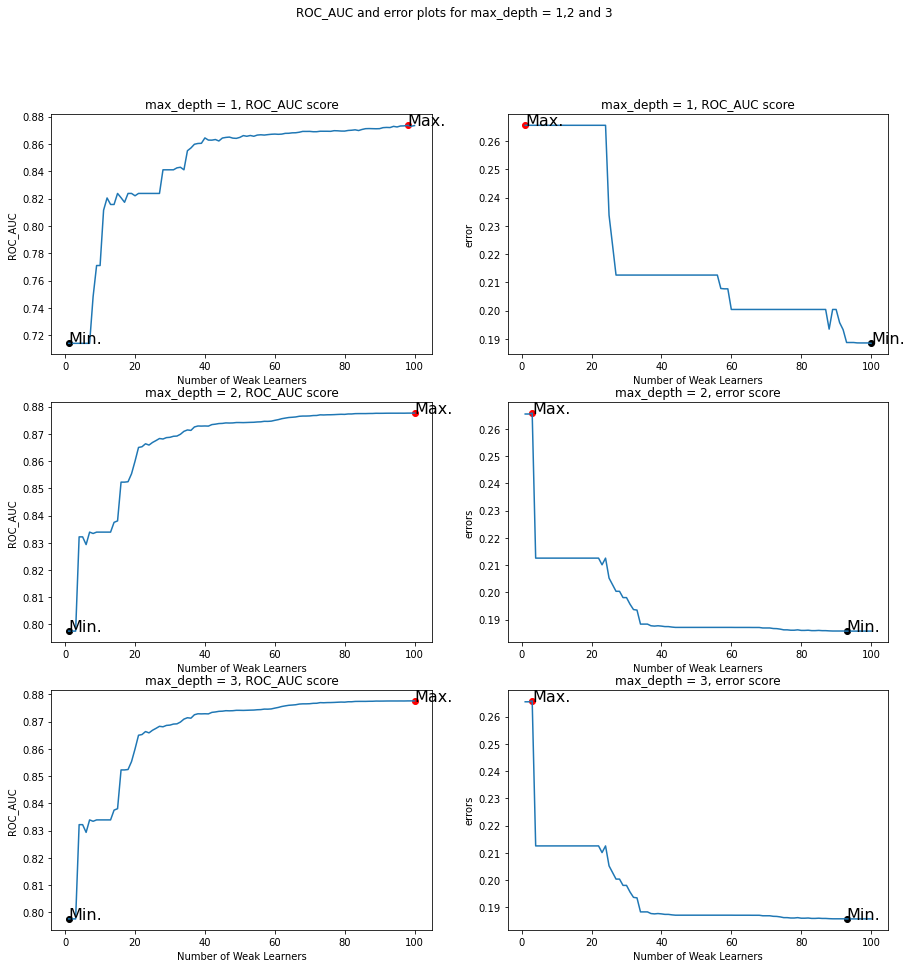

In [25]:
fig, axs = plt.subplots(4,2,figsize=(15,15))
fig.suptitle('ROC_AUC and error plots for max_depth = 1,2 and 3 ')
axs[0,0].plot(range(1,len(roc_auc_1_mean)+1), roc_auc_1_mean)
axs[0,0].scatter([range(1,len(roc_auc_1_mean)+1)[np.argmin(roc_auc_1_mean)]], 
            [np.min(roc_auc_1_mean)], c='k')
axs[0,0].scatter([range(1,len(roc_auc_1_mean)+1)[np.argmax(roc_auc_1_mean)]], 
            [np.max(roc_auc_1_mean)], c='r')
axs[0,0].text(range(1,len(roc_auc_1_mean)+1)[np.argmin(roc_auc_1_mean)], 
         np.min(roc_auc_1_mean), "Min.", fontsize=16)
axs[0,0].text(range(1,len(roc_auc_1_mean)+1)[np.argmax(roc_auc_1_mean)], 
         np.max(roc_auc_1_mean), "Max.", fontsize=16)
axs[0,0].set_title('max_depth = 1, ROC_AUC score')
axs[0,0].set(xlabel='Number of Weak Learners', ylabel='ROC_AUC' )


axs[0,1].plot(range(1,len(acc_1_mean)+1), acc_1_mean)
axs[0,1].scatter([range(1,len(acc_1_mean)+1)[np.argmin(acc_1_mean)]], 
            [np.min(acc_1_mean)], c='k')
axs[0,1].scatter([range(1,len(acc_1_mean)+1)[np.argmax(acc_1_mean)]], 
            [np.max(acc_1_mean)], c='r')
axs[0,1].text(range(1,len(acc_1_mean)+1)[np.argmin(acc_1_mean)], 
         np.min(acc_1_mean), "Min.", fontsize=16)
axs[0,1].text(range(1,len(acc_1_mean)+1)[np.argmax(acc_1_mean)], 
         np.max(acc_1_mean), "Max.", fontsize=16)
axs[0,1].set_title('max_depth = 1, ROC_AUC score')
axs[0,1].set(xlabel='Number of Weak Learners', ylabel='error' )


axs[1,0].plot(range(1,len(roc_auc_2_mean)+1), roc_auc_2_mean)
axs[1,0].scatter([range(1,len(roc_auc_2_mean)+1)[np.argmin(roc_auc_2_mean)]], 
            [np.min(roc_auc_2_mean)], c='k')
axs[1,0].scatter([range(1,len(roc_auc_2_mean)+1)[np.argmax(roc_auc_2_mean)]], 
            [np.max(roc_auc_2_mean)], c='r')
axs[1,0].text(range(1,len(roc_auc_2_mean)+1)[np.argmin(roc_auc_2_mean)], 
         np.min(roc_auc_2_mean), "Min.", fontsize=16)
axs[1,0].text(range(1,len(roc_auc_2_mean)+1)[np.argmax(roc_auc_2_mean)], 
         np.max(roc_auc_2_mean), "Max.", fontsize=16)
axs[1,0].set_title('max_depth = 2, ROC_AUC score')
axs[1,0].set(xlabel='Number of Weak Learners', ylabel='ROC_AUC' )


axs[1,1].plot(range(1,len(acc_2_mean)+1), acc_2_mean)
axs[1,1].scatter([range(1,len(acc_2_mean)+1)[np.argmin(acc_2_mean)]], 
            [np.min(acc_2_mean)], c='k')
axs[1,1].scatter([range(1,len(acc_2_mean)+1)[np.argmax(acc_2_mean)]], 
            [np.max(acc_2_mean)], c='r')
axs[1,1].text(range(1,len(acc_2_mean)+1)[np.argmin(acc_2_mean)], 
         np.min(acc_2_mean), "Min.", fontsize=16)
axs[1,1].text(range(1,len(acc_2_mean)+1)[np.argmax(acc_2_mean)], 
         np.max(acc_2_mean), "Max.", fontsize=16)
axs[1,1].set_title('max_depth = 2, error score')
axs[1,1].set(xlabel='Number of Weak Learners', ylabel='errors' )

axs[2,0].plot(range(1,len(roc_auc_3_mean)+1), roc_auc_3_mean)
axs[2,0].scatter([range(1,len(roc_auc_3_mean)+1)[np.argmin(roc_auc_3_mean)]], 
            [np.min(roc_auc_3_mean)], c='k')
axs[2,0].scatter([range(1,len(roc_auc_3_mean)+1)[np.argmax(roc_auc_3_mean)]], 
            [np.max(roc_auc_3_mean)], c='r')
axs[2,0].text(range(1,len(roc_auc_3_mean)+1)[np.argmin(roc_auc_3_mean)], 
         np.min(roc_auc_3_mean), "Min.", fontsize=16)
axs[2,0].text(range(1,len(roc_auc_3_mean)+1)[np.argmax(roc_auc_3_mean)], 
         np.max(roc_auc_3_mean), "Max.", fontsize=16)
axs[2,0].set_title('max_depth = 3, ROC_AUC score')
axs[2,0].set(xlabel='Number of Weak Learners', ylabel='ROC_AUC' )


axs[2,1].plot(range(1,len(acc_3_mean)+1), acc_3_mean)
axs[2,1].scatter([range(1,len(acc_3_mean)+1)[np.argmin(acc_3_mean)]], 
            [np.min(acc_3_mean)], c='k')
axs[2,1].scatter([range(1,len(acc_3_mean)+1)[np.argmax(acc_3_mean)]], 
            [np.max(acc_3_mean)], c='r')
axs[2,1].text(range(1,len(acc_3_mean)+1)[np.argmin(acc_3_mean)], 
         np.min(acc_3_mean), "Min.", fontsize=16)
axs[2,1].text(range(1,len(acc_3_mean)+1)[np.argmax(acc_3_mean)], 
         np.max(acc_3_mean), "Max.", fontsize=16)
axs[2,1].set_title('max_depth = 3, error score')
axs[2,1].set(xlabel='Number of Weak Learners', ylabel='errors' )
#############uptohere need to change!!!!!
axs[3,0].plot(range(1,len(roc_auc_1_mean)+1), roc_auc_1_mean,'r',label='max_depth=1')
axs[3,0].plot(range(1,len(roc_auc_2_mean)+1), roc_auc_2_mean,'b',label = 'max_depth=2')
axs[3,0].plot(range(1,len(roc_auc_3_mean)+1), roc_auc_3_mean,'b',label = 'max_depth=2')
axs[3,0].set_title('tree_method = approx and hist, ROC_AUC score')
axs[3,0].set(xlabel='Number of Weak Learners', ylabel='ROC_AUC' )
axs[3,0].legend()

axs[3,1].plot(range(1,len(acc_approx_mean)+1), acc_approx_mean,'r',label='approx')
axs[3,1].plot(range(1,len(acc_hist_mean)+1), acc_hist_mean,'b',label = 'hist')
axs[3,1].set_title('tree_method = approx and hist, error score')
axs[3,1].set(xlabel='Number of Weak Learners', ylabel='error' )
axs[3,1].legend()

It appers that the performance of these two methods are very similar. A quick note: from the plot it seems that although the as numer of iterations increase error ingeneral decrease and ROC_AUC score increas, however, since the socre did not change much between iter = 90~100, maybe it's better to use around 90 iterations, since it gives a simpler model.

In [3]:
def xgboost_tune(max_depth :int, subsample :float, 
                 tree_method :str,n_estimators :int, 
                 eta:float, kf_n_splits :int, data_train, target_train ) -> list:
    
    skf = StratifiedKFold(n_splits=kf_n_splits)
    xgb_clf = xgb.XGBClassifier(booster = 'gbtree',
                                objective = 'binary:logistic',
                                max_depth = max_depth,
                                subsample = subsample,
                                tree_method = tree_method,
                                eval_metric = 'auc',
                                n_estimators=n_estimators,
                                eta =eta,
                                use_label_encoder=False)

    roc_auc = [[0] * n_estimators] * kf_n_splits
    i = 0
    for train_index, test_index in skf.split(data_train,target_train):
        data_train_train, data_train_hold = data_train.iloc[train_index], data_train.iloc[test_index]
        target_train_train, target_train_hold = target_train.iloc[train_index], target_train.iloc[test_index]
        xgb_clf_clone = clone(xgb_clf)
        xgb_clf_clone.fit(data_train_train,target_train_train,
                          eval_set = [(data_train_hold,target_train_hold)],verbose = False)
        roc_auc[i] = xgb_clf_clone.evals_result()['validation_0']['auc']
        i = i+1

    return roc_auc
    

In [7]:
roc_auc = xgboost_tune(max_depth = , subsample = 0.5, 
                       tree_method = 'approx' ,n_estimators = 70, 
                       eta = 0.1, kf_n_splits = 5, data_train = X_train, target_train = Y_train)

In [8]:
vec = np.array(roc_auc).mean(0)
length = len(vec)
print('The optimal number of weak learner for this xgbooster is ', np.argmax(vec)+1, 
      'it achieve an roc_auc score of ',np.max(vec).round(6),'.')

The optimal number of weak learner for this xgbooster is  48 it achieve an roc_auc score of  0.873669 .


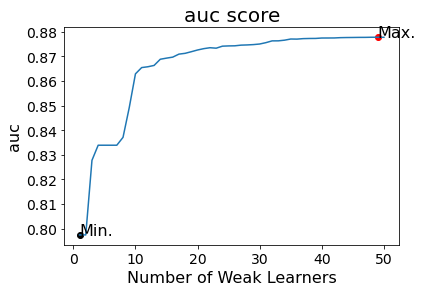

In [6]:
plt.plot(range(1,length+1), vec)
plt.scatter([range(1,length+1)[np.argmin(vec)]], 
            [np.min(vec)], c='k')
plt.scatter([range(1,length+1)[np.argmax(vec)]], 
            [np.max(vec)], c='r')
plt.text(range(1,length+1)[np.argmin(vec)], 
         np.min(vec), "Min.", fontsize=16)
plt.text(range(1,length+1)[np.argmax(vec)], 
         np.max(vec), "Max.", fontsize=16)

plt.title("auc score", fontsize=20)
plt.xlabel("Number of Weak Learners", fontsize=16)
plt.ylabel("auc", fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

In [9]:
xgb.__version__

'1.5.0'

AttributeError: module 'sklearn.metrics' has no attribute '__version__'

In [16]:
sklearn.__version__

'1.0.1'

In [20]:
A = range(1,4)

In [21]:
A

range(1, 4)

In [22]:
for i in range(1,4):
    print(i)

1
2
3
